# Setup

You started working with the Capital Bike Share dataset in Homework 2 and 3. We're going to extend our work there to try to predict ridership.

Our basic goal will be to try to predict ridership in 2012 based on ridership data in 2011. So the 2011 data will be our *training set* and the 2012 data will be our *test set* (aka *held-out* data or sometimes *validation* data).

First, we'll load up the data.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

# Set some display settings.
sns.set(context='notebook')

In [2]:
hourly_counts_orig = pd.read_csv('data/hour.csv')
hourly_counts_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


## Question 1.1: Renaming
Some of those column names are pretty awful. It's as if the authors didn't know that they could (usually) tab-complete column names! Let's fix a few of them up.

In [3]:
hourly_counts = hourly_counts_orig.rename(columns={
    'dteday': 'date',
    'hr': "hour",
    'mnth': "month",
    'weekday': "day_of_week",
    'holiday': "is_holiday",
    'workingday': "is_workingday",
    'weathersit': "precip_type",
    "hum": "humidity",
    'cnt': "rides"
}).drop(["instant", "casual", "registered"], axis=1)
hourly_counts['date'] = pd.to_datetime(hourly_counts['date'])
hourly_counts['day_of_year'] = hourly_counts['date'].dt.dayofyear
cols = list(hourly_counts.columns)
cols.insert(1, cols.pop(cols.index("day_of_year")))
cols.insert(4, cols.pop(cols.index("day_of_week")))
cols.insert(4, cols.pop(cols.index("day_of_week")))
hourly_counts = hourly_counts[cols]
hourly_counts.head()

,date,day_of_year,season,yr,day_of_week,month,hour,is_holiday,is_workingday,precip_type,temp,atemp,humidity,windspeed,rides
0,2011-01-01,1,1,0,6,1,0,0,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,1,0,6,1,1,0,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,1,0,6,1,2,0,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,1,0,6,1,3,0,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,1,0,6,1,4,0,0,1,0.24,0.2879,0.75,0.0,1


In [4]:
assert hourly_counts['hour'].max() == 23
assert hourly_counts['rides'].max() > 900

# HACK!

Close your eyes for this section... we're doing something messy to make the rest of this exercise make more sense.

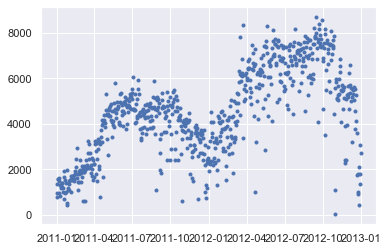

In [5]:
plt.plot(hourly_counts.groupby('date').rides.sum(), '.')

There were many more rides in 2012 than in 2011.

In [6]:
hourly_counts.groupby('yr').rides.sum()

yr
0    1243103
1    2049576
Name: rides, dtype: int64

To make things comparable, let's normalize by popularity. Of course we wouldn't actually *know* the total popularity of 2012 during that year, which is why this particular approach is labeled "HACK!".

In [7]:
year_means = hourly_counts.groupby('yr').rides.mean()
ratio = year_means[1] / year_means[0]
print("Scaling test set by", ratio)

Scaling test set by 1.6319570412428936


In [8]:
hourly_counts['rides'] = np.where(hourly_counts.yr == 0, hourly_counts.rides, hourly_counts.rides / ratio)
hourly_counts.groupby('yr').rides.mean()

yr
0    143.794448
1    143.794448
Name: rides, dtype: float64

End hack. You can open your eyes now.

## Train-Test Split
We're going to use 2011 as the training set and 2012 as the test set.

In [9]:
hourly_counts.yr.value_counts()

1    8734
0    8645
Name: yr, dtype: int64

In [10]:
train = hourly_counts[hourly_counts.yr == 0]
test = hourly_counts[hourly_counts.yr == 1]

In [11]:
assert train['date'].iloc[0].date().isoformat() == '2011-01-01'
assert test['date'].iloc[0].date().isoformat() == '2012-01-01'
assert all(train['date'].dt.year == 2011)
assert all(test['date'].dt.year == 2012)
assert len(train) + len(test) == len(hourly_counts)

In [12]:
train.drop(["yr"], axis=1).head()

,date,day_of_year,season,day_of_week,month,hour,is_holiday,is_workingday,precip_type,temp,atemp,humidity,windspeed,rides
0,2011-01-01,1,1,6,1,0,0,0,1,0.24,0.2879,0.81,0.0,16.0
1,2011-01-01,1,1,6,1,1,0,0,1,0.22,0.2727,0.80,0.0,40.0
2,2011-01-01,1,1,6,1,2,0,0,1,0.22,0.2727,0.80,0.0,32.0
3,2011-01-01,1,1,6,1,3,0,0,1,0.24,0.2879,0.75,0.0,13.0
4,2011-01-01,1,1,6,1,4,0,0,1,0.24,0.2879,0.75,0.0,1.0


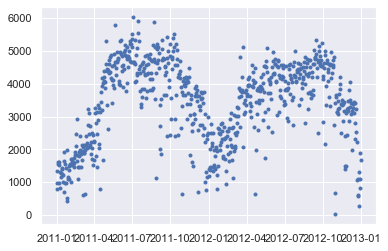

In [13]:
plt.plot(hourly_counts.groupby('date').rides.sum(), '.')

# Single Predictor

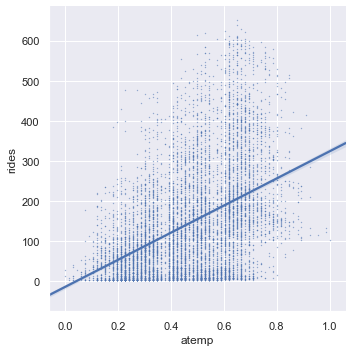

In [14]:
sns.lmplot(x='atemp', y='rides', data=train, scatter_kws={'s': .1})

In [15]:
def transform(data):
    return data[['atemp']]

train_X = transform(train)
train_y = train['rides']
test_X = transform(test)
test_y = test['rides']

In [16]:
temp_only_model = LinearRegression().fit(train_X, train_y)

In [17]:
temp_only_model.intercept_

-14.904552347416939

In [18]:
temp_only_model.coef_

array([338.37707325])

In [19]:
train_y_pred = temp_only_model.predict(train_X)

In [20]:
# Write this number down
# NOTE: make sure you're computing the error on the *predictions* vs the *observed*
metrics.mean_squared_error(train_y, train_y_pred)

14322.798088054105

In [21]:
metrics.r2_score(train_y, train_y_pred)

0.19983451811060304

In [22]:
test_y_pred = temp_only_model.predict(test_X)
metrics.r2_score(test_y, test_y_pred)

0.15392631009935875

## Add in `month`

In [23]:
def transform(data):
    return data[['atemp', 'month']]

train_X = transform(train)
train_y = train['rides']
test_X = transform(test)
test_y = test['rides']

In [24]:
temp_and_month_model = LinearRegression().fit(train_X, train_y)

In [25]:
temp_only_model.coef_

array([338.37707325])

In [26]:
temp_and_month_model.coef_

array([325.58265007,   2.41934852])

Why did the coef of `temp` change?

In [27]:
train_y_pred = temp_and_month_model.predict(train_X)

How will the training set MSE change compared with having just `atemp`?

In [28]:
metrics.mean_squared_error(train_y, train_y_pred)

14259.13153107234

In [29]:
metrics.r2_score(train_y, train_y_pred)

0.20339134973905704

How will the test set MSE / R2 change?

In [30]:
test_y_pred = temp_and_month_model.predict(test_X)
metrics.r2_score(test_y, test_y_pred)

0.1561551536900354

# Try a one-hot encoding for month

In [33]:
train['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [47]:
def transform(data):
    X = data[['atemp']].copy()
    for month in range(1, 12):
        X[f'month_{month}'] = (data['month'] == month).astype(float)
    return X

train_X = transform(train)
train_y = train['rides']
test_X = transform(test)
test_y = test['rides']
train_X.head()

,atemp,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
0,0.2879,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.2727,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2727,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.2879,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.2879,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
model = LinearRegression().fit(train_X, train_y)

In [55]:
model.intercept_

-51.586486951983915

In [56]:
model.coef_

array([ 513.37797856,    2.48896184,  -20.80957203,  -27.46645206,
        -50.88710173,  -48.63396536,  -81.02067143, -123.27635533,
        -98.01774682,  -62.60574683,  -17.66818841,  -11.25610762])

In [57]:
metrics.r2_score(train_y, model.predict(train_X))

0.22931665521516553

In [58]:
# ABSOLUTELY NEVER DO THIS: model.fit(test_X, test_y)

metrics.r2_score(test_y, model.predict(test_X))

0.18593388131415722